<a href="https://colab.research.google.com/github/amkayhani/FAIDM/blob/main/RFE_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive Feature Elimination (RFE)

A practical guide with a real-world classification example (scikit-learn)



## What you’ll learn

By the end of this notebook, you’ll be able to:

- Explain *why* feature selection matters and where RFE fits in.
- Describe how RFE works (and what it assumes about your estimator).
- Use **RFE** and **RFECV** in scikit-learn inside a **Pipeline** (without data leakage).
- Interpret feature rankings/selection and compare models **with vs without** RFE.
- Recognise common pitfalls (leakage, instability, collinearity, computational cost).



## Why feature selection?

Feature selection is the process of choosing a subset of input variables (features) for your model.

It’s useful when you have:

- **Many features** relative to samples (risk of overfitting).
- **Redundant / collinear features** (harder to interpret, sometimes slower to fit).
- **Noisy features** that add variance without adding signal.
- A need for **interpretability** (a smaller set is easier to explain).

There are three broad families:

1. **Filter methods** (pre-model): e.g. correlation thresholding, mutual information.
2. **Wrapper methods** (model-in-the-loop): e.g. RFE, forward/backward selection.
3. **Embedded methods** (feature selection happens during training): e.g. L1 (Lasso), tree-based selection.

RFE is a classic **wrapper** method: it repeatedly trains a model and *removes* the least useful features.



## RFE in plain English

**Recursive Feature Elimination (RFE)** works like this:

1. Start with *all* features.
2. Fit an estimator.
3. Rank features by “importance” (usually the magnitude of coefficients or feature importances).
4. Remove the least important feature(s).
5. Repeat until you have the desired number of features.

### Key assumptions

RFE needs an estimator that can provide feature importance:

- `coef_` (linear models like Logistic Regression, Linear/Ridge/Lasso, linear SVMs)
- `feature_importances_` (many tree models)

### Variant: RFECV

**RFECV** (RFE + cross-validation) automatically chooses how many features to keep by evaluating performance for different subset sizes using cross-validation.


### Practical knobs you’ll actually tune

- **How many features to keep?** (`n_features_to_select`)  
  Fixed-size selection is common when you need a shortlist for deployment or reporting.

- **How aggressively to eliminate?** (`step`)  
  `step=1` removes one feature per iteration (more granular, slower). Larger steps are faster but can skip over good subsets.

- **What estimator to rank with?**  
  RFE inherits the biases of the estimator. If your estimator can’t capture the relevant structure, RFE won’t magically fix that.




---


**Important nuance:** coefficient magnitudes are only comparable when features are on similar scales — hence the importance of scaling for many linear estimators.


In practice, you rarely need the maths to *use* RFE, but it’s handy for understanding why:

- Scaling matters for coefficient-based rankings.
- Regularisation can stabilise rankings when features are correlated.
- The “best” subset depends on your scoring metric and cross-validation strategy.


# Real-world example: breast cancer diagnosis (classification)

We’ll use scikit-learn’s **Breast Cancer Wisconsin (Diagnostic)** dataset, built from digitised images of fine needle aspirate (FNA) of breast masses.

**Task:** predict whether a tumour is **malignant** or **benign** using 30 numeric features describing cell nuclei (e.g. radius, texture, perimeter).

Why this is a good “real-world” demo for RFE:
- The dataset has **many correlated measurements** (common in biomedical and sensor data).
- A smaller feature set can be valuable for **interpretability** and **measurement cost**.
- Logistic regression is a standard baseline used in clinical ML settings.

We’ll compare:
1. **Baseline** logistic regression using all features
2. Logistic regression with **RFE** (keep a fixed number of features)
3. Logistic regression with **RFECV** (choose the number of features via cross-validation)

**Metrics:** Accuracy and ROC-AUC (using predicted probabilities). We’ll also inspect confusion matrices to see which errors are being made.


In [1]:
# Core numerical + data handling
import numpy as np
import pandas as pd

# Plotting (we'll use this for the confusion matrices and RFECV curve)
import matplotlib.pyplot as plt

# Rich notebook display
from IPython.display import display

# Dataset
from sklearn.datasets import load_breast_cancer

# Train/test splitting and CV helpers
from sklearn.model_selection import train_test_split, StratifiedKFold

# Pipelines help prevent data leakage by keeping preprocessing + selection + modelling together
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Estimator (a strong baseline for tabular classification)
from sklearn.linear_model import LogisticRegression

# Feature selection
from sklearn.feature_selection import RFE, RFECV

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Reproducibility (note: some algorithms still have minor nondeterminism depending on BLAS/backends)
np.random.seed(42)


In [2]:
# Load the dataset as a pandas DataFrame for easier inspection
data = load_breast_cancer(as_frame=True)

# Features (30 measurements)
X = data.data.copy()

# Target: in this dataset 0 = malignant, 1 = benign
y = data.target.copy()

print("Feature matrix shape:", X.shape)
print("Target distribution (0=malignant, 1=benign):")
display(y.value_counts())

# Optional: see the human-readable target names
print("Target names:", data.target_names)

# Peek at the feature columns
display(X.head())


Feature matrix shape: (569, 30)
Target distribution (0=malignant, 1=benign):


,count
target,
1,357
0,212


Target names: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Quick exploratory look

Before modelling, it’s worth doing a quick sanity-check on the data:

- **Descriptive statistics**: spot weird ranges, near-constant features, or unexpected scales.
- **Target balance**: for classification, check class proportions (imbalanced data can make accuracy misleading).
- **Simple associations**: correlations can be a fast way to see which features *tend* to move with the target.

A couple of important caveats:

- Correlation is **not causation**, and in a multivariate model a feature can matter even if its univariate correlation is small.
- Many features here are correlated with each other; that’s a classic situation where feature selection can be **unstable** (different “equally good” subsets).
- This is exploratory: we’re not using any test-set information for feature selection — that happens inside a Pipeline later.


In [3]:
# Basic descriptive stats for each feature
# Useful for spotting weird ranges or near-constant features.
display(X.describe().T)

# Quick univariate association with the target via correlation.
# NOTE:
# - Correlation is sensitive to scaling and outliers.
# - In multivariate models, a feature can matter even if its univariate correlation is small.
corr = X.join(pd.Series(y, name="target")).corr(numeric_only=True)["target"].sort_values()

display(corr)


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


,target
worst concave points,-0.793566
worst perimeter,-0.782914
mean concave points,-0.776614
worst radius,-0.776454
mean perimeter,-0.742636
worst area,-0.733825
mean radius,-0.730029
mean area,-0.708984
mean concavity,-0.696360
worst concavity,-0.659610


## Train/test split

We’ll keep a held-out **test set** that we do *not* touch during feature selection.

Because this is classification, we use a **stratified** split so the malignant/benign proportions stay similar in train and test.

In real projects you’d often go one step further and use **nested cross-validation** to avoid optimistic estimates when you tune both
hyperparameters and feature selection. Here, we’ll keep it simple and use a single train/test split plus cross-validation inside RFECV.


In [4]:
# Keep a held-out test set for final evaluation.
# Stratify preserves the class proportions in each split.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

print("Train shape:", X_train.shape)
print("Test shape: ", X_test.shape)


Train shape: (426, 30)
Test shape:  (143, 30)


## Baseline model (all features)

We start with a strong, simple baseline: **Logistic Regression** with standardisation.

Why standardise?
- Logistic regression is a linear model; coefficient magnitudes depend on the feature scale.
- RFE’s ranking for linear models often relies on coefficients, so scaling is important.

Why ROC-AUC?
- ROC-AUC evaluates ranking quality using **probabilities**, not a fixed decision threshold.
- It’s useful when you care about discrimination performance independent of a specific threshold.

We’ll still compute **accuracy** too, but don’t treat it as the only headline metric.


In [5]:
# Baseline model: Standardise -> Logistic Regression
# Why scaling?
# - Logistic regression coefficients depend on feature scale.
# - RFE (for linear models) often uses coefficient magnitudes as the ranking signal.
baseline = Pipeline([
    ("scale", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=5000,
        solver="liblinear",   # solid choice for smaller/binary problems
        random_state=42
    ))
])

# Fit only on training data (no leakage)
baseline.fit(X_train, y_train)

# Predict probabilities for the positive class (benign = 1 here)
proba = baseline.predict_proba(X_test)[:, 1]

# Default decision threshold of 0.5
pred = (proba >= 0.5).astype(int)

# Metrics:
# - Accuracy depends on a threshold.
# - ROC-AUC uses probabilities and is threshold-independent.
baseline_metrics = {
    "Accuracy": accuracy_score(y_test, pred),
    "ROC-AUC": roc_auc_score(y_test, proba),
}

baseline_metrics


{'Accuracy': 0.986013986013986, 'ROC-AUC': np.float64(0.9976939203354298)}

## Feature importance (baseline)

For linear models like Logistic Regression, a simple “importance” proxy is the **magnitude of the fitted coefficients**.

Because we standardise features, coefficient magnitudes are on a comparable scale and can be interpreted as:
- larger absolute value → stronger influence on the predicted log-odds (for a one standard-deviation change in the feature)

We’ll plot the top features by absolute coefficient magnitude.


,feature,coef,abs_coef
21,worst texture,-1.239292,1.239292
10,radius error,-1.076423,1.076423
13,area error,-0.973467,0.973467
23,worst area,-0.961703,0.961703
28,worst symmetry,-0.944810,0.944810
27,worst concave points,-0.940689,0.940689
20,worst radius,-0.918686,0.918686
26,worst concavity,-0.807607,0.807607
22,worst perimeter,-0.724127,0.724127
5,mean compactness,0.714430,0.714430


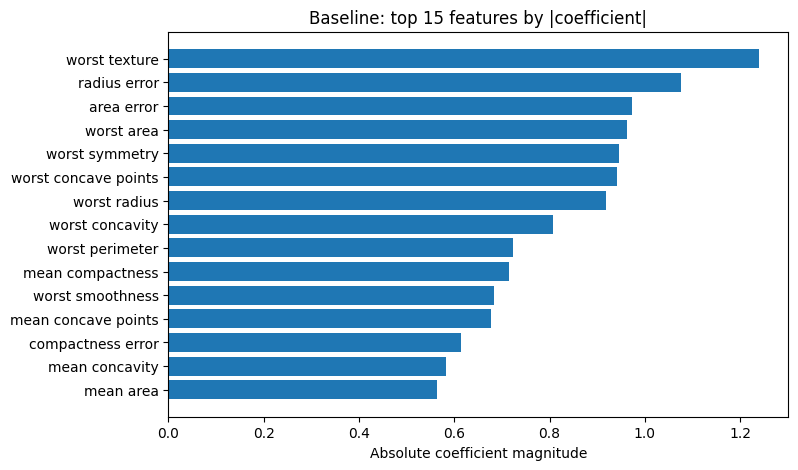

In [6]:
# --- Baseline feature importance via coefficient magnitude ---
# For binary logistic regression, coef_ has shape (1, n_features).
coefs = baseline.named_steps["model"].coef_.ravel()

importance = pd.DataFrame({
    "feature": X.columns,
    "coef": coefs,
    "abs_coef": np.abs(coefs),
}).sort_values("abs_coef", ascending=False)

display(importance.head(15))

# Plot the top 15 features by absolute coefficient
topk = 15
top = importance.head(topk).sort_values("abs_coef")  # sort for nicer horizontal plot

plt.figure(figsize=(8, 5))
plt.barh(top["feature"], top["abs_coef"])
plt.xlabel("Absolute coefficient magnitude")
plt.title(f"Baseline: top {topk} features by |coefficient|")
plt.show()


## Confusion matrix (baseline)

A confusion matrix breaks predictions down by **true class vs predicted class**.

It’s especially useful when the “cost” of errors differs:
- **False negatives** (malignant predicted as benign) can be far more serious than false positives in screening contexts.

We’ll show the confusion matrix using a default 0.5 threshold. Later, you can explore threshold tuning as an exercise.


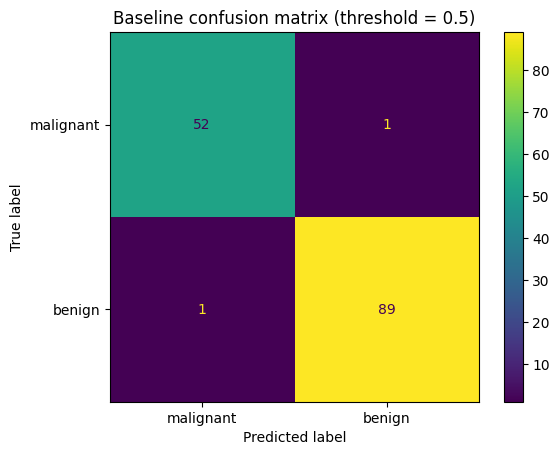

In [7]:
# Confusion matrix for the baseline model
# We'll explicitly set label order: 0 (malignant) then 1 (benign)
cm = confusion_matrix(y_test, pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["malignant", "benign"]
)
disp.plot()

plt.title("Baseline confusion matrix (threshold = 0.5)")
plt.show()


## RFE with a fixed number of features

Now we apply **RFE** to keep a fixed-size subset (here: 10 features).

Key choices:

- `n_features_to_select`: how many features you want to keep.
- `step`: how many features to drop per iteration. `step=1` is thorough but can be slower.
- `estimator`: must expose feature importance (for Logistic Regression we use `coef_`).

**Important:** RFE must happen *inside* a Pipeline so that feature selection is learned using only training data (no leakage).


In [8]:
# RFE model: Standardise -> RFE(LogReg) -> Logistic Regression
#
# IMPORTANT:
# - RFE must be fitted on training data only; a Pipeline enforces that.
# - We use the same estimator family for selection and the final model for consistency.
# - n_features_to_select controls the final subset size.
rfe_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("select", RFE(
        estimator=LogisticRegression(max_iter=5000, solver="liblinear", random_state=42),
        n_features_to_select=10,
        step=1  # remove one feature per iteration (more thorough, slower)
    )),
    ("model", LogisticRegression(max_iter=5000, solver="liblinear", random_state=42))
])

rfe_pipeline.fit(X_train, y_train)

proba_rfe = rfe_pipeline.predict_proba(X_test)[:, 1]
pred_rfe = (proba_rfe >= 0.5).astype(int)

rfe_metrics = {
    "Accuracy": accuracy_score(y_test, pred_rfe),
    "ROC-AUC": roc_auc_score(y_test, proba_rfe),
}

rfe_metrics


{'Accuracy': 0.972027972027972, 'ROC-AUC': np.float64(0.9974842767295597)}

## Confusion matrix (RFE)

Same idea as before, but now for the feature-selected model.

If accuracy stays high but the confusion matrix shifts, it might indicate a trade-off between different types of errors.
That’s often where threshold tuning becomes important.


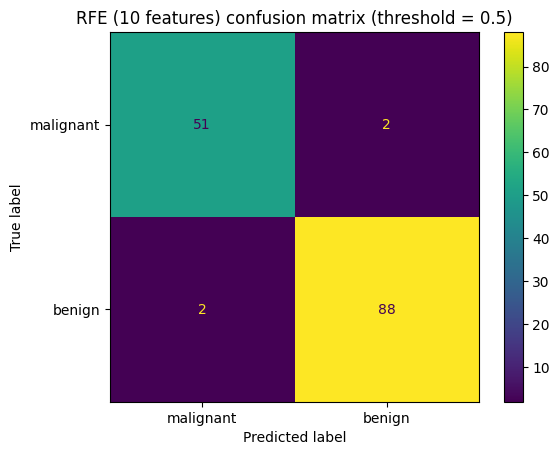

In [9]:
# Confusion matrix for the RFE-selected model
cm = confusion_matrix(y_test, pred_rfe, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["malignant", "benign"]
)
disp.plot()

plt.title("RFE (10 features) confusion matrix (threshold = 0.5)")
plt.show()


## Compare baseline vs RFE and inspect selected features

Beyond metrics, we want to understand **what RFE chose**:

- `support_`: a boolean mask of selected features.
- `ranking_`: rank 1 means “kept”; higher numbers were eliminated earlier (less important under this estimator).

Remember: rankings are conditional on the model choice, regularisation, scaling, and the particular train split.
With correlated features, several subsets can perform similarly — RFE may pick one representative from a correlated group.


In [10]:
# Compare metrics side by side
comparison = pd.DataFrame(
    [baseline_metrics, rfe_metrics],
    index=["Baseline (all features)", "RFE (10 features)"]
)
display(comparison)

# Inspect which features were selected
selector = rfe_pipeline.named_steps["select"]

# support_ is a boolean mask of selected features
selected_mask = selector.support_

# ranking_: 1 means "kept", higher numbers were eliminated earlier
ranking = selector.ranking_

ranking_table = pd.DataFrame({
    "feature": X.columns,
    "selected": selected_mask,
    "rank (1 = kept)": ranking,
}).sort_values(["rank (1 = kept)", "feature"])

display(ranking_table)

selected_features = X.columns[selected_mask].tolist()
print("Selected features:", selected_features)


,Accuracy,ROC-AUC
Baseline (all features),0.986014,0.997694
RFE (10 features),0.972028,0.997484


,feature,selected,rank (1 = kept)
13,area error,True,1
3,mean area,True,1
10,radius error,True,1
23,worst area,True,1
27,worst concave points,True,1
26,worst concavity,True,1
22,worst perimeter,True,1
20,worst radius,True,1
24,worst smoothness,True,1
21,worst texture,True,1


Selected features: ['mean area', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points']


## Feature ranking diagram (RFE)

RFE gives every feature a **rank**:
- Rank **1**: selected (kept)
- Rank **2+**: eliminated earlier (less useful under this estimator)

Below, we plot the full ranking so you can see where the “cut” happens at 10 features.


In [15]:
# --- RFE ranking diagram ---
selector = rfe_pipeline.named_steps["select"]
ranking_df = pd.DataFrame({
    "feature": X.columns,
    "rank": selector.ranking_,
    "selected": selector.support_,
}).sort_values(["rank", "feature"])

display(ranking_df)


,feature,rank,selected
13,area error,1,True
3,mean area,1,True
10,radius error,1,True
23,worst area,1,True
27,worst concave points,1,True
26,worst concavity,1,True
22,worst perimeter,1,True
20,worst radius,1,True
24,worst smoothness,1,True
21,worst texture,1,True


## RFECV: pick the number of features automatically

Instead of choosing “10 features” up front, **RFECV** tries different subset sizes and uses cross-validation to pick the best number.

We’ll use:
- **StratifiedKFold** to preserve class proportions in each fold.
- `scoring="roc_auc"` so selection is driven by discrimination performance.
- `min_features_to_select=1` to allow full exploration down to a single feature.

RFECV is more principled than picking an arbitrary feature count, but it’s also more computationally expensive.


In [12]:
# RFECV: RFE + cross-validation to choose the number of features automatically
#
# We use StratifiedKFold to keep class proportions similar across folds.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("select", RFECV(
        estimator=LogisticRegression(max_iter=5000, solver="liblinear", random_state=42),
        step=1,
        cv=cv,
        scoring="roc_auc",
        min_features_to_select=1
    )),
    ("model", LogisticRegression(max_iter=5000, solver="liblinear", random_state=42))
])

rfecv_pipeline.fit(X_train, y_train)

proba_rfecv = rfecv_pipeline.predict_proba(X_test)[:, 1]
pred_rfecv = (proba_rfecv >= 0.5).astype(int)

rfecv_metrics = {
    "Accuracy": accuracy_score(y_test, pred_rfecv),
    "ROC-AUC": roc_auc_score(y_test, proba_rfecv),
}

rfecv_metrics


{'Accuracy': 0.9790209790209791, 'ROC-AUC': np.float64(0.9976939203354298)}

## Visualising RFECV’s choice

RFECV evaluates model performance for different numbers of retained features.

The plot below shows cross-validated ROC-AUC as the feature count changes. The peak (or plateau) typically indicates a good trade-off:
- **Too few features** → underfitting
- **Too many features** → diminishing returns (and sometimes worse generalisation)

We’ll also print the selected feature names.


Optimal number of features (by CV): 15
Selected features: ['mean radius', 'mean texture', 'mean area', 'mean concave points', 'radius error', 'area error', 'compactness error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry']


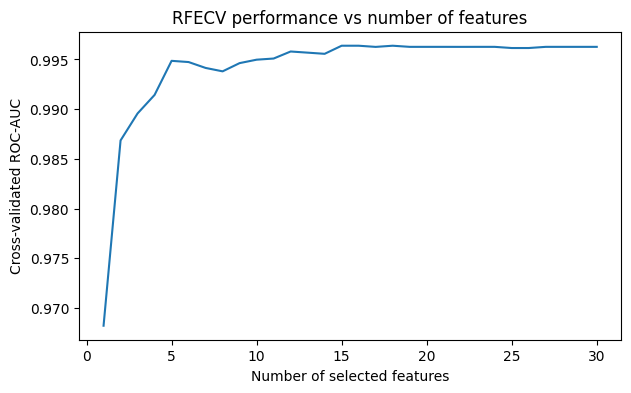

In [13]:
# Extract RFECV results and plot CV score vs number of selected features
rfecv_selector = rfecv_pipeline.named_steps["select"]

print("Optimal number of features (by CV):", rfecv_selector.n_features_)

opt_features = X.columns[rfecv_selector.support_].tolist()
print("Selected features:", opt_features)

# scikit-learn stores RFECV scores differently across versions; handle common cases.
scores = None
n_features = None

if hasattr(rfecv_selector, "cv_results_") and "mean_test_score" in rfecv_selector.cv_results_:
    scores = rfecv_selector.cv_results_["mean_test_score"]
    n_features = rfecv_selector.cv_results_["n_features"]
elif hasattr(rfecv_selector, "grid_scores_"):
    scores = rfecv_selector.grid_scores_
    n_features = np.arange(1, len(scores) + 1)

plt.figure(figsize=(7, 4))
plt.plot(n_features, scores)
plt.xlabel("Number of selected features")
plt.ylabel("Cross-validated ROC-AUC")
plt.title("RFECV performance vs number of features")
plt.show()


## Compare all approaches

Here we put the results side by side:

- Baseline: all features
- RFE: fixed small set (interpretability-focused)
- RFECV: automatically selected count (performance-focused)

If performance is similar but the feature set is smaller, that’s often a practical win — fewer measurements, simpler explanations,
and potentially more robust deployment (depending on data drift and measurement noise).


In [14]:
# Final comparison table across all approaches
comparison2 = pd.DataFrame(
    [baseline_metrics, rfe_metrics, rfecv_metrics],
    index=["Baseline (all features)", "RFE (10 features)", "RFECV (auto)"]
)
display(comparison2)


,Accuracy,ROC-AUC
Baseline (all features),0.986014,0.997694
RFE (10 features),0.972028,0.997484
RFECV (auto),0.979021,0.997694



## Interpreting the results

A few things to look for:

- If **RFE** or **RFECV** performs similarly to the baseline but uses fewer features, that’s often a win:
  - simpler model
  - easier to explain
  - potentially cheaper to measure in practice

- If performance drops noticeably, it can mean:
  - useful features were removed, or
  - the estimator used for ranking isn’t a good match for the task

### Don’t over-interpret rankings

Feature rankings depend on:
- the estimator choice,
- regularisation strength,
- feature scaling,
- and the data split.

For correlated features, several different subsets can perform similarly — RFE may choose one of many “good” options.



## Common pitfalls (and how to dodge them)

### 1) Data leakage
If you run RFE on the full dataset *before* splitting, you leak information from the test set into feature selection.

**Fix:** use a Pipeline and fit only on training data.

### 2) Not scaling when you should
Coefficient magnitudes are sensitive to feature scales.

**Fix:** standardise features for linear models unless you have a reason not to.

### 3) Unstable selections
With correlated features, small changes in data can change the chosen subset.

**Fix:** regularisation, cross-validation, and stability checks (see the advanced exercise).

### 4) Computational cost
RFE can be slow: it fits the estimator many times.

**Fix:** increase `step`, do a quick filter step first, or use embedded methods (L1, trees).



## Extensions you might try next

- Swap Logistic Regression for a **linear SVM** (`LinearSVC`) and compare.
- Try a **tree model** (e.g. RandomForestClassifier) and use RFE via `feature_importances_`.
- Compare RFE to an embedded method like **L1-regularised Logistic Regression**.
- Evaluate with **nested CV** if you want an honest end-to-end performance estimate.


# Exercises (three levels)

Keep these short and practical. Use Pipelines so you don’t leak information across splits.

---

## Exercise 1 — Beginner

Run **RFE + Logistic Regression** on the **digits** dataset.

- Build a pipeline: `StandardScaler → RFE(LogisticRegression, select 15) → LogisticRegression`
- Report **accuracy** and **macro F1**
- Print the selected `pixel_*` feature names

---

## Exercise 2 — Intermediate

Using the **breast cancer RFECV** model, try three probability thresholds: **0.3, 0.5, 0.7**.

- For each threshold, compute a confusion matrix
- Pick one threshold and explain the trade-off (who benefits, what error is reduced)

---

## Exercise 3 — Advanced

Check how stable RFE is.

- Repeat RFE (10 features) across **30** different train/test splits
- Count how often each feature is selected
- Plot selection frequency and name the top 5 most consistently selected features
